In [1]:
# Based on https://lablab.ai/t/stable-diffusion-inpainting

import torch
import requests
from PIL import Image
from torchvision import transforms

from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

2022-12-15 22:18:01.055443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 22:18:01.665451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda-11.4/extras/Debugger/lib64:/usr/local/cuda-11.4/extras/Debugger/include
2022-12-15 22:18:01.665500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

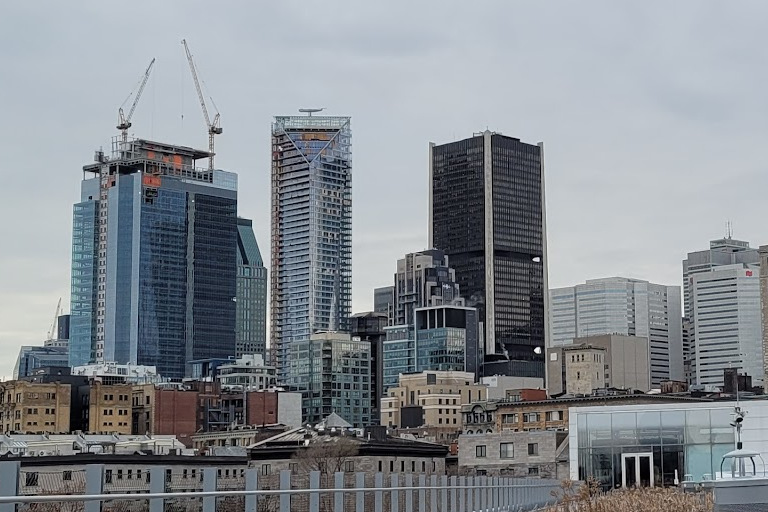

In [20]:

from PIL import Image
init_img = Image.open("/home/pawel/git/NeuralNetworksSketchbook/city.jpg").convert("RGB")
init_img

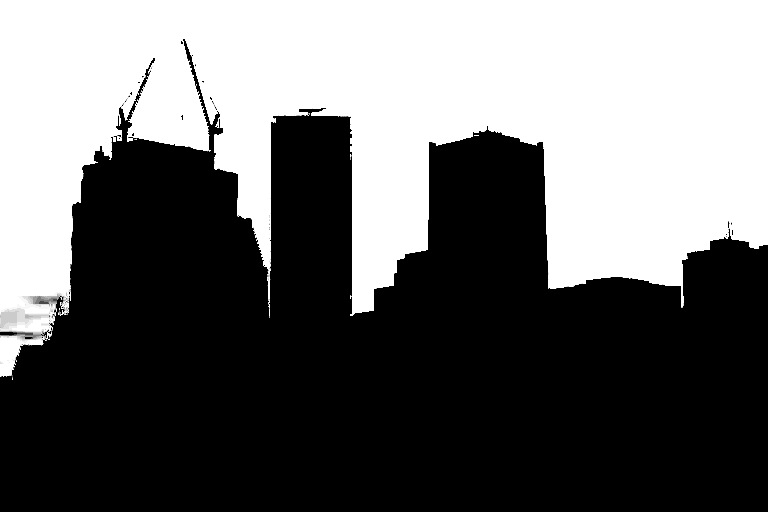

In [21]:
mask = Image.open("/home/pawel/git/NeuralNetworksSketchbook/city_mask.jpg").convert("RGB")
mask

In [22]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/home/pawel/projekty/aiart/venv/lib/python3.8/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  warnings.warn(warning + message, FutureWarning)


  0%|          | 0/41 [00:00<?, ?it/s]

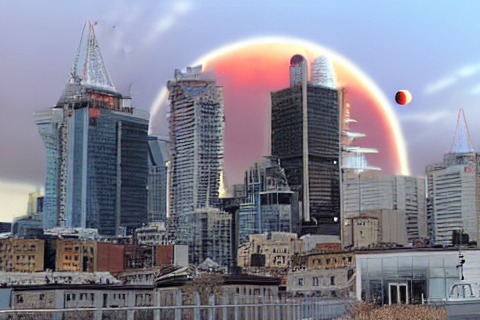

In [60]:
init_img_ = init_img.copy()
mask_ = mask.copy()
size = [2*i/3 for i in init_img.size]
init_img_.thumbnail(size, Image.Resampling.LANCZOS)
mask_.thumbnail(size, Image.Resampling.LANCZOS)
with autocast("cuda"):
    images = pipe(prompt="A red sky from out of space, with puffy clouds and two moons, trending on artstation, profesional", init_image=init_img_, mask_image=mask_, strength=0.8).images
images[0]

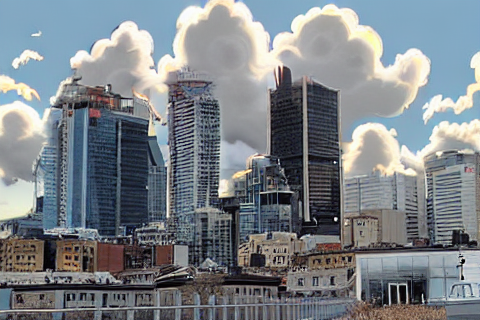

In [49]:
images[0]

In [90]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

image = Image.open("/home/pawel/git/NeuralNetworksSketchbook/car.jpg").convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

In [96]:
i = 0

In [121]:
import numpy as np
# Overlay colormap on mask

from torch import nn

upsampled_logits = nn.functional.interpolate(logits,
                size=(image.size[1], image.size[0]), # (height, width)
                mode='bilinear',
                align_corners=False)

predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()[0]
#for i,c in color_map.items():

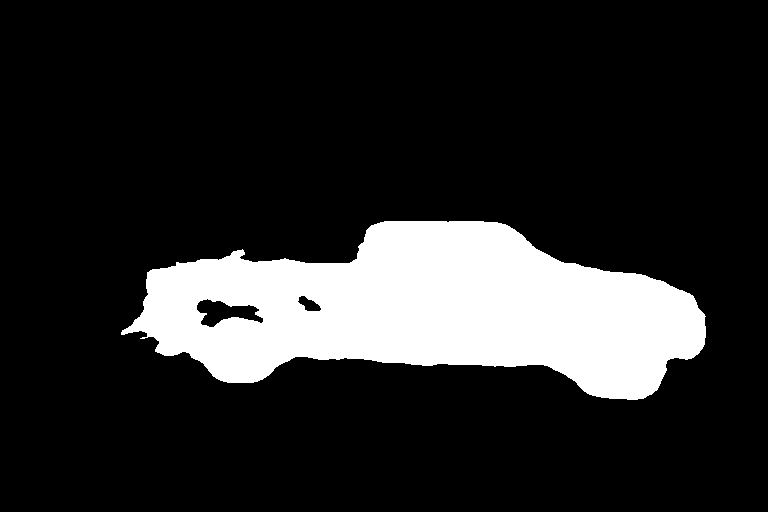

In [207]:
i = 20
vis = np.zeros(predicted_mask.shape + (3,))
vis[predicted_mask == i] = [255, 255, 255]

mask = Image.fromarray(vis.astype(np.uint8)) # covert to pillow image.
mask = mask.resize(image.size) # resize to original image size
mask

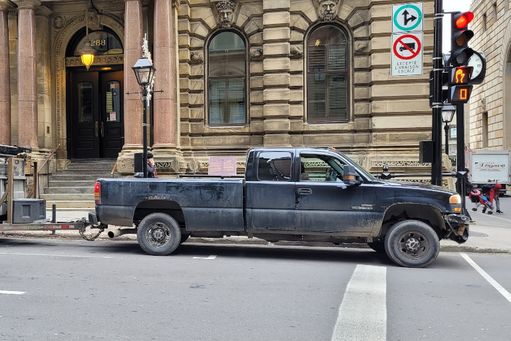

In [152]:
init_img = Image.open("/home/pawel/git/NeuralNetworksSketchbook/car.jpg").convert("RGB")
init_img_ = init_img.copy()
mask_ = mask.copy()
size = [2*i/3 for i in init_img.size]
init_img_.thumbnail(size, Image.Resampling.LANCZOS)
mask_.thumbnail(size, Image.Resampling.LANCZOS)
init_img_

  0%|          | 0/21 [00:00<?, ?it/s]

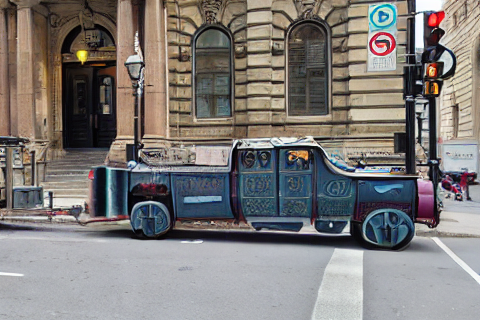

In [192]:
with autocast("cuda"):
    images = pipe(prompt="A steampunk train, highly detailed, professional", init_image=init_img_, mask_image=mask_, strength=0.4).images
images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

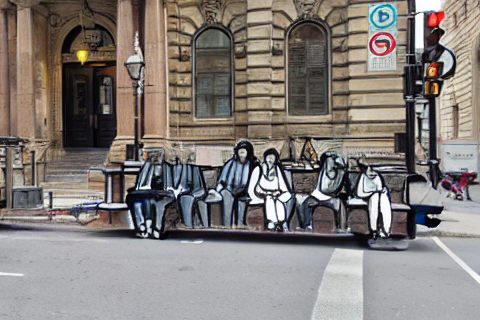

In [231]:
with autocast("cuda"):
    images = pipe(prompt="A sketch of a crowd waiting for a bus, sitting, highly detailed, professional", init_image=init_img_, mask_image=mask_, strength=1.0).images
images[0]

  0%|          | 0/46 [00:00<?, ?it/s]

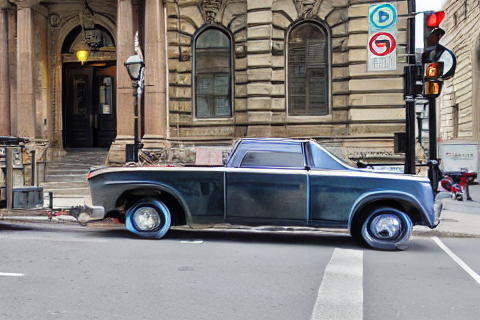

In [282]:
with autocast("cuda"):
    images = pipe(prompt="A toy car, highly detailed, professional",  num_inference_steps=75, guidance_scale=3.5, init_image=init_img_, mask_image=mask_, strength=0.6).images
images[0]